### Anaconda environment

- pip install tensorflow_hub
- pip install notebook
- pip install matplotlib
- pip install scipy
- pip install tensorflow-gpu
    - conda install cudatoolkit=11.2 cudnn=8.1 -c=conda-forge  | installs latest compatable versions of cuda and cudnn
- pip install tensorflow   |use if you dont have a gpu


### IMPORTS

In [2]:

import matplotlib.pylab as plt  #used for image visualizations
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
#Checks if gpu is available
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num Gpus Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num Gpus Available:  1


### IDENTIFYING DIRECTORIES

In [4]:
# size of expected images
IMAGE_SHAPE = (224,224)

#folder directories change these to you folder directories
train_dir = "F:/EVERYTHINGELSE/BLENDERFILES/RENDEROUTPUT/SYNTHETICDATASETCARS/train"
validation_dir = "F:/EVERYTHINGELSE/BLENDERFILES/RENDEROUTPUT/SYNTHETICDATASETCARS/val"
test_dir = "F:/EVERYTHINGELSE/BLENDERFILES/RENDEROUTPUT/SYNTHETICDATASETCARS/test"

In [5]:
# Uses tensorflow to preprocess the images , any file under a directory will be labled with that directory
train_image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = train_image_generator.flow_from_directory(directory=train_dir, shuffle=True,  target_size=IMAGE_SHAPE)

Found 906 images belonging to 3 classes.


In [6]:
validation_image_generator = ImageDataGenerator(rescale=1./255)
validation_data_gen = train_image_generator.flow_from_directory(directory=validation_dir, shuffle=True,  target_size=IMAGE_SHAPE)

Found 264 images belonging to 3 classes.


In [7]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = train_image_generator.flow_from_directory(directory=test_dir, shuffle=True,  target_size=IMAGE_SHAPE)

Found 30 images belonging to 3 classes.


### DISPLAY DATA

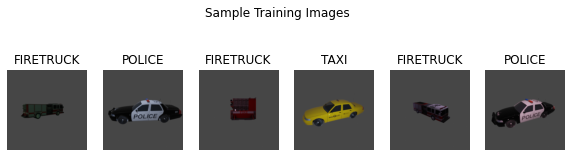

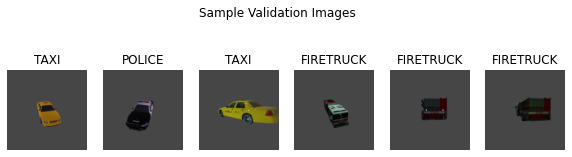

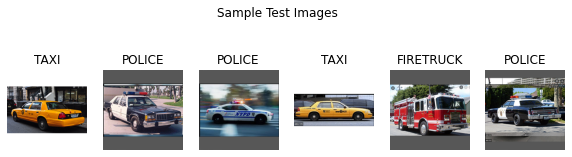

In [8]:
# creates a function that Takes in the data and title and then displays it using mathplot
# Synthetic data has been randomly generated camera angles and lighting scenarios
def display_samples(data_gen, title):
    classes = dict()
    for key, val in data_gen.class_indices.items():
        classes[val] = key
    sample_images, sample_labels = next(data_gen)

    plt.figure(figsize=(10,3))
    plt.subplots_adjust(hspace=0.5)
    for n in range(6):
            plt.subplot(1,6,n+1)
            plt.imshow(sample_images[n])
            plt.title(classes[np.argmax(sample_labels[n])])
            plt.axis('off')
            _= plt.suptitle(title)
display_samples(train_data_gen, 'Sample Training Images')
display_samples(validation_data_gen, 'Sample Validation Images')
display_samples(test_data_gen, 'Sample Test Images')

## Create the TensorFlow Model

In [9]:
# Creates a tensorflow model using transfer learning from mobilenet v2
num_classes = len(train_data_gen.class_indices)
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5",
    trainable=False,input_shape=IMAGE_SHAPE + (3,)),
    tf.keras.layers.Dense(num_classes,activation='softmax')
    ])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
#compiles the model
model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

### TRAIN MODEL

In [11]:
# typically arround 4 - 3 epochs will be good enough to train the image
train_steps_per_epoch = np.ceil(train_data_gen.samples/train_data_gen.batch_size)
val_steps_per_epoch = np.ceil(validation_data_gen.samples/validation_data_gen.batch_size)

epochs = 4

history = model.fit(
train_data_gen, 
epochs = epochs,
steps_per_epoch=train_steps_per_epoch,
validation_data=validation_data_gen, 
validation_steps = val_steps_per_epoch)


Epoch 1/4


D:\ANACONDA\envs\tf\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


29/29 [==============================] - 28s 294ms/step - loss: 0.3949 - acc: 0.8675 - val_loss: 0.0685 - val_acc: 1.0000
Epoch 2/4
29/29 [==============================] - 3s 96ms/step - loss: 0.0425 - acc: 1.0000 - val_loss: 0.0266 - val_acc: 1.0000
Epoch 3/4
29/29 [==============================] - 3s 97ms/step - loss: 0.0216 - acc: 1.0000 - val_loss: 0.0174 - val_acc: 1.0000
Epoch 4/4
29/29 [==============================] - 3s 95ms/step - loss: 0.0150 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 1.0000


### INFERENCE

In [12]:
# Tests model trained on synthetic data with real life images of vehicles, there are 10 images for each vehicle

class_names = np.empty([len(test_data_gen.class_indices)], dtype=object, order='C')
for key, val in test_data_gen.class_indices.items():
    class_names[val]= key


test_data_gen.reset()
image_batch, label_batch = next(test_data_gen)

predicted_batch= model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)

### Show Predictions

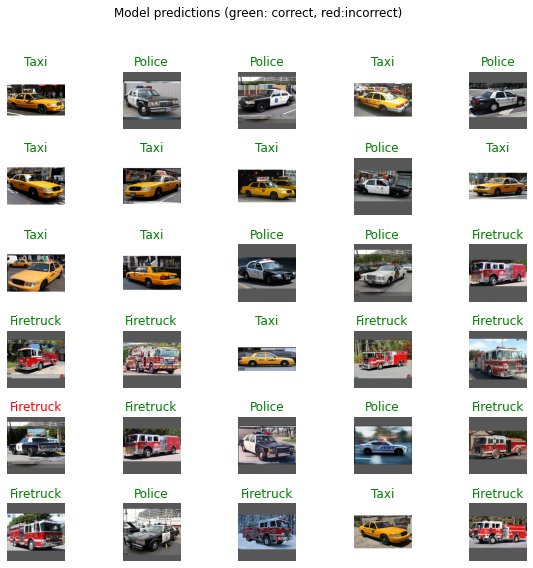

In [13]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(min(30, len(image_batch))):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color="green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(),color=color)
    plt.axis('off')
    plt.suptitle("Model predictions (green: correct, red:incorrect)")

# The model generated from this method will typically be able to classify these 30 real world vehicals that it has never seen with arround a 90 - 100% accuracy rating